In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from time import time

Let's start with implementing the Metropolis rule. Encapsulating this task allows us to reuse it elsewhere, write unit tests, and replace it easily inside other functions.

This function should accept the current position, create a trial position, and return either the trial or the current position.

(0, 1)

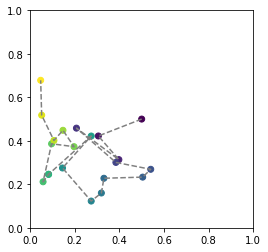

In [2]:
def metropolis_uniform_unit_square(xy, width=0.4):
    '''Generate a Markov chain using the Metropolis rule.
    
    We generate a Markov chain of random displacements inside a unit square;
    this function implements the update rule and returns either a new valid
    position inside the unit square or the supplied argument if the
    displacement would lead out of the unit square.
    
    Arguments:
        xy (ndarray): current position inside the unit square
        width (float): width of the trial square around the current position
    '''
    xy_trial = xy + width * (np.random.rand(*xy.shape) - 0.5)
    if np.all(xy_trial >= 0.0) and np.all(xy_trial <= 1.0):
         return xy_trial
    return xy

markov_chain = [np.asarray([0.5, 0.5])]
for i in range(20):
    markov_chain.append(metropolis_uniform_unit_square(markov_chain[-1]))
markov_chain = np.asarray(markov_chain)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(*markov_chain.T, '--', color='grey')
ax.scatter(*markov_chain.T, c=range(len(markov_chain)))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

We generated a short Markov chain and visualized how the walker moves inside the unit square. The colors indicate the rank inside the sequence where dark indicates early and light indicates later elements of the Markov chain.

Let's now implement the approximation function and reuse our Metropolis rule:

In [3]:
def approximate_pi_mcmc(n_sample, width=0.4):
    '''Approximate pi using Metropolis MCMC.
    
    We generate a Markov chain of random displacements inside a unit square
    and, thus, sample the area ratio between a quarter unit circle and the
    unit square.
    
    Arguments:
        n_sample (int): number of update steps in the Markov chain
        width (float): width of the trial square around the current position
    '''
    summation = 0
    xy = np.random.rand(2)
    for i in range(n_sample):
        xy = metropolis_uniform_unit_square(xy, width=width)
        if np.sum(xy**2) <= 1.0:
            summation += 1
    return 4.0 * summation / float(n_sample)

start = time()
pi = approximate_pi_mcmc(100000)
finish = time()
print('pi   = %.5f' % pi)
print('time = %.3f seconds' % (finish - start))

pi   = 3.10800
time = 2.467 seconds


We observe that this approach is much slower than the vectorized direct MC. This is because we have to use a pure python loop as we iterate over the Markov chain, and python loops are slow.

As a final step, let's do a rough statistical analysis to understand how the two parameters ``n_sample`` and ``width`` influence the calculation. To this aim, we write another function ``sample`` which runs ``approximate_pi_mcmc`` several times for a given parameter choice and returns a list with all generated pi estimates.

In [4]:
def sample(n_rep, n_sample, width=0.4):
    '''Benchmark the approximation of pi using Metropolis MCMC.
    
    We repeatedly call approximate_pi_mcmc and return a list with
    the pi estimates for further analysis.
    
    Arguments:
        n_rep (int): number of repetitions
        n_sample (int): number of update steps in the Markov chain
        width (float): width of the trial square around the current position
    '''
    return [approximate_pi_mcmc(n_sample, width=width) for i in range(n_rep)]

We can then fix one parameter and vary the other, and visualize how the quality of the pi approximation changes with the variable parameter. Let's fix ``width=0.4`` (which is the default) and examine the dependency on the length of the Markov chain by plotting the mean and the full range of results for each choice of ``n_sample``:

[]

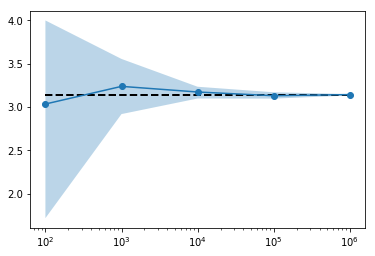

In [5]:
n_sample = [100, 1000, 10000, 100000, 1000000]
pi = [sample(10, n, width=0.4) for n in n_sample]

plt.plot(n_sample, [np.pi] * len(n_sample), '--', color='black', lw=2)
plt.fill_between(n_sample, np.min(pi, axis=1), np.max(pi, axis=1), alpha=0.3)
plt.plot(n_sample, np.mean(pi, axis=1), '-o')
plt.semilogx()

We observe that the mean converges towards the true value and that the approximation errors decay with increasing ``n_sample``.

How does the choice of ``width`` influence the approximation quality?

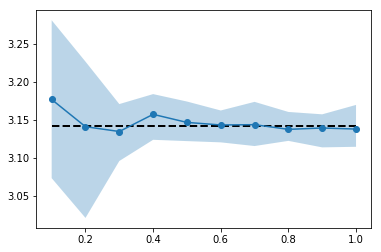

In [6]:
width = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
pi = [sample(10, 100000, width=w) for w in width]

plt.plot(width, [np.pi] * len(width), '--', color='black', lw=2)
plt.fill_between(width, np.min(pi, axis=1), np.max(pi, axis=1), alpha=0.3)
plt.plot(width, np.mean(pi, axis=1), '-o')

We observe that the sampling is much less sensitive towards the ``width`` than towards ``n_sample``, but we nevertheless observe that a small ``width`` seems to worsen the approximation quality. At this point we could formulate the hypothesis that a small step size slows down the sampling.

Any idea how we could test this hypothesis?